In [ ]:
!git clone https://github.com/RafaelB411/DPIR.git

%cd /content/DPIR

Cloning into 'DPIR'...
remote: Enumerating objects: 239, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 239 (delta 48), reused 35 (delta 35), pack-reused 179
Receiving objects: 100% (239/239), 6.85 MiB | 31.03 MiB/s, done.
Resolving deltas: 100% (104/104), done.
/content/DPIR


In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append('/content/DPIR/')

## Baixando modelos

In [ ]:
import argparse
import re
from main_download_pretrained_models import download_pretrained_model

parser = argparse.ArgumentParser()
parser.add_argument('--models',
                     type=lambda s: re.split(' |, ', s),
                     default = "dncnn3.pth",
                     help='comma or space delimited list of characters, e.g., "DnCNN", "DnCNN BSRGAN.pth", "dncnn_15.pth dncnn_50.pth"')
parser.add_argument('--model_dir', type=str, default='model_zoo', help='path of model_zoo')
args, unknown = parser.parse_known_args()

method_model_zoo = {'DnCNN': ['dncnn_15.pth', 'dncnn_25.pth', 'dncnn_50.pth', 'dncnn3.pth', 'dncnn_color_blind.pth', 'dncnn_gray_blind.pth'],
                    'SRMD': ['srmdnf_x2.pth', 'srmdnf_x3.pth', 'srmdnf_x4.pth', 'srmd_x2.pth', 'srmd_x3.pth', 'srmd_x4.pth'],
                    'DPSR': ['dpsr_x2.pth', 'dpsr_x3.pth', 'dpsr_x4.pth', 'dpsr_x4_gan.pth'],
                    'FFDNet': ['ffdnet_color.pth', 'ffdnet_gray.pth', 'ffdnet_color_clip.pth', 'ffdnet_gray_clip.pth'],
                    'USRNet': ['usrgan.pth', 'usrgan_tiny.pth', 'usrnet.pth', 'usrnet_tiny.pth'],
                    'DPIR': ['drunet_gray.pth', 'drunet_color.pth', 'drunet_deblocking_color.pth', 'drunet_deblocking_grayscale.pth'],
                    'BSRGAN': ['BSRGAN.pth', 'BSRNet.pth', 'BSRGANx2.pth'],
                    'IRCNN': ['ircnn_color.pth', 'ircnn_gray.pth'],
                    'others': ['msrresnet_x4_psnr.pth', 'msrresnet_x4_gan.pth', 'imdn_x4.pth', 'RRDB.pth', 'ESRGAN.pth',
                               'FSSR_DPED.pth', 'FSSR_JPEG.pth', 'RealSR_DPED.pth', 'RealSR_JPEG.pth']}

method_zoo = list(method_model_zoo.keys())
model_zoo = []
for b in list(method_model_zoo.values()):
   model_zoo += b

# method_zoo = ['DPIR', 'IRCNN']
# model_zoo = ['drunet_gray.pth', 'drunet_color.pth', 'drunet_deblocking_color.pth',
#              'drunet_deblocking_grayscale.pth', 'ircnn_color.pth', 'ircnn_gray.pth']

# setting models we'll use
args.models = ['drunet_color.pth', 'ircnn_color.pth', 'drunet_gray.pth', 'ircnn_gray.pth']

print(f'trying to download {args.models}')

for method_model in args.models:
   download_pretrained_model(args.model_dir, method_model)

trying to download ['drunet_color.pth', 'ircnn_color.pth', 'drunet_gray.pth', 'ircnn_gray.pth']
already exists, skip downloading [drunet_color.pth]
already exists, skip downloading [ircnn_color.pth]
already exists, skip downloading [drunet_gray.pth]
already exists, skip downloading [ircnn_gray.pth]


## Demosaicing

### Inicializando parâmetros

A gente pode alterar os parâmetros abaixo e observar as mudanças nos resultados finais.
Deixamos como exercício essas alterações

In [ ]:
import torch

# initialization
noise_level_img = 25.0/255.0          # set AWGN noise level for LR image, default: 0
noise_level_model = noise_level_img   # set noise level of model, default: 0
model_name = 'ircnn_color'            # set denoiser, 'drunet_color' | 'ircnn_color'
                                      # demosaicing must use full color models
testset_name = 'set5'                 # set testing set, you can set your own
x8 = True                             # set PGSE to boost performance, default: True
iter_num = 40                         # set number of iterations, default: 40 for demosaicing
modelSigma1 = 49                      # set sigma_1, default: 49
modelSigma2 = max(0.6, noise_level_model*255.)  # set sigma_2, default
matlab_init = False

border = 10                           # default 10 for demosaicing

task_current = 'dm'                   # 'dm' for demosaicing
n_channels = 3                        # 3 channels = RGB image
model_zoo = 'model_zoo'
testsets = 'testsets'
results = 'results'
result_name = testset_name + '_' + task_current + '_' + model_name
model_path = os.path.join(model_zoo, model_name+'.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

### Configurando os caminhos das imagens

In [ ]:
import logging
from utils import utils_logger, utils_image as util

# setting images' paths
L_path = os.path.join(testsets, testset_name) # for Low-quality images
E_path = os.path.join(results, result_name)   # for Estimated images
util.mkdir(E_path)

logger_name = result_name
utils_logger.logger_info(logger_name, log_path=os.path.join(E_path, logger_name+'.log'))
logger = logging.getLogger(logger_name)

LogHandlers exists!


### Carregando modelo

In [ ]:
from utils import utils_model, utils_mosaic, utils_pnp as pnp
from collections import OrderedDict

# loading model
if 'drunet' in model_name:
   from models.network_unet import UNetRes as net
   model = net(in_nc=n_channels+1, out_nc=n_channels, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose")
   model.load_state_dict(torch.load(model_path), strict=True)
   model.eval()
   for _, v in model.named_parameters():
      v.requires_grad = False
   model = model.to(device)
elif 'ircnn' in model_name:
   from models.network_dncnn import IRCNN as net
   model = net(in_nc=n_channels, out_nc=n_channels, nc=64)
   model25 = torch.load(model_path)
   former_idx = 0

print('model_name: {}, image sigma: {:.3f}, model sigma: {:.3f}'.format(model_name, noise_level_img, noise_level_model))
print('Model path: {:s}'.format(model_path))
print('Images path: {:s}'.format(L_path))
L_paths = util.get_image_paths(L_path)

test_results = OrderedDict()
test_results['psnr'] = []

model_name: ircnn_color, image sigma: 0.098, model sigma: 0.098
Model path: model_zoo/ircnn_color.pth
Images path: testsets/set5


---1--> baby_GT.bmp -- PSNR: 25.35dB


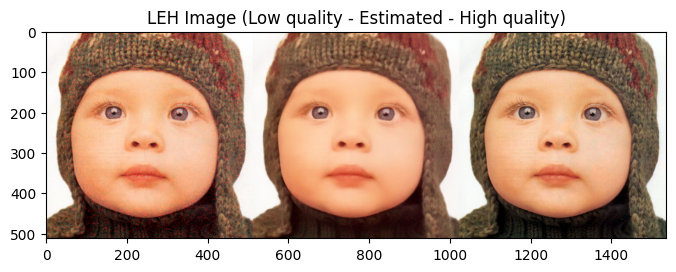

---2--> bird_GT.bmp -- PSNR: 23.33dB


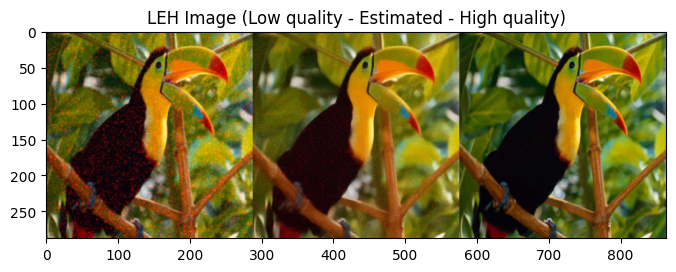

---3--> butterfly_GT.bmp -- PSNR: 24.23dB


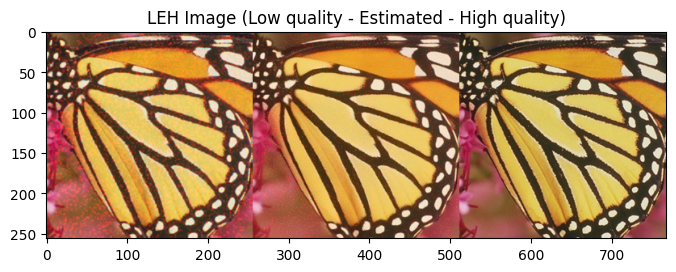

---4--> head_GT.bmp -- PSNR: 23.57dB


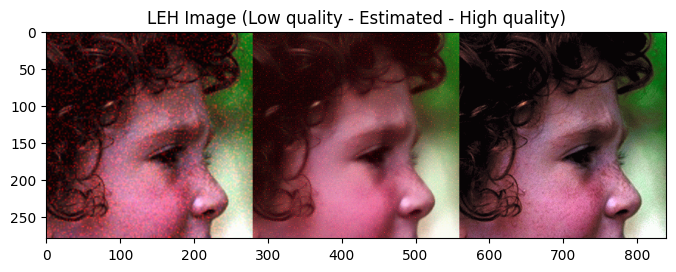

---5--> woman_GT.bmp -- PSNR: 25.52dB


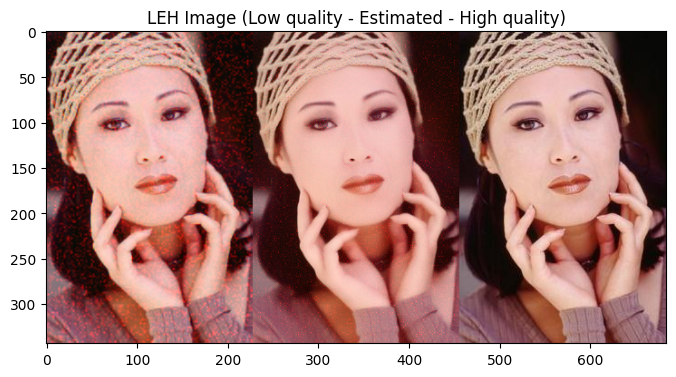

------> Average PSNR(RGB) of (set5) is : 24.40 dB


In [ ]:
for idx, img in enumerate(L_paths):

   # (1) get img_H (high-quality) and img_L (low-quality)
   # a imagem em alta qualidade é lida do repositório 'testsets' no
   # formato RGB e armazenada em img_H, geramos ruído sobre a imagem
   # e extraímos seus filtros usando um filtro de Bayer como base
   idx += 1
   img_name, ext = os.path.splitext(os.path.basename(img))
   img_H = util.imread_uint(img, n_channels=n_channels)

   # noise generator
   noise = np.zeros(img_H.shape, np.uint8)
   cv2.randn(noise, mean=0, stddev=50)
   noisy_img = cv2.add(img_H, noise)

   CFA, CFA4, mosaic, mask = utils_mosaic.mosaic_CFA_Bayer(noisy_img)

   # (2) initialize x
   # convertemos o quadro de pixels obtido a partir do filtro CFA da imagem
   # em uma imagem colorida e a armazenamos na variável x, convertendo-a para
   # o formato de tensor (array numérico), essa será a imagem base em baixa
   # qualidade com a qual trabalharemos (img_L)
   if matlab_init:  # matlab demosaicing for initialization
      CFA4 = util.uint2tensor4(CFA4).to(device)
      x = utils_mosaic.dm_matlab(CFA4)

   else:
      x = cv2.cvtColor(CFA, cv2.COLOR_BAYER_BG2RGB_EA)
      x = util.uint2tensor4(x).to(device)

   img_L = util.tensor2uint(x)

   # convertendo o mosaico e a máscara em tensores
   y = util.uint2tensor4(mosaic).to(device)
   mask = util.single2tensor4(mask.astype(np.float32)).to(device)

   # (3) get rhos and sigmas
   # definindo os parâmetros rho e sigma da imagem, que definem o posicionamento
   # de linhas e a intensidade de blurring na imagem, respectivamente
   rhos, sigmas = pnp.get_rho_sigma(sigma=max(0.255/255., noise_level_img), iter_num=iter_num, modelSigma1=modelSigma1, modelSigma2=modelSigma2, w=1.0)
   rhos, sigmas = torch.tensor(rhos).to(device), torch.tensor(sigmas).to(device)

   # (4) main iterations
   for i in range(iter_num):

      # step 1, closed-form solution
      # aplicando o mosaico e a máscara à imagem base, utilizando o parâmetro
      # rho para preservar a composição das linhas da imagem
      x = (y+rhos[i].float()*x).div(mask+rhos[i])

      # step 2, denoiser
      # aplicamos a imagem no modelo selecionado para tratá-la e tentar
      # restaurá-la, removendo o ruído e aumentando a qualidade da imagem
      if 'ircnn' in model_name:
         current_idx = np.int64(np.ceil(sigmas[i].cpu().numpy()*255.0/2.0)-1)
         if current_idx != former_idx and current_idx < 25:
            model.load_state_dict(model25[str(current_idx)], strict=True)
            model.eval()
            for _, v in model.named_parameters():
               v.requires_grad = False
            model = model.to(device)
         former_idx = current_idx

      # ajustando os valores dos pixels da imagem para o intervalo[0,1]
      # se o valor do pixel for menor que 0, ele é corrigido para 0
      # se o valor do pixel for maior que 1, ele é corrigido para 1
      x = torch.clamp(x, 0, 1)

      # alterando a orientação da imagem para otimizar o funcionamento do modelo
      if x8:
         x = util.augment_img_tensor4(x, i % 8)

      # aplicação do modelo de processamento
      if 'drunet' in model_name:
         x = torch.cat((x, sigmas[i].float().repeat(1, 1, x.shape[2], x.shape[3])), dim=1)
         x = utils_model.test_mode(model, x, mode=2, refield=32, min_size=256, modulo=16)
      elif 'ircnn' in model_name:
         x = model(x)

      # retornando a imagem à sua orientação original
      if x8:
         if i % 8 == 3 or i % 8 == 5:
            x = util.augment_img_tensor4(x, 8 - i % 8)

         else:
            x = util.augment_img_tensor4(x, i % 8)

   # igualando os valores booleanos da máscara aplicada ao mosaico aos valores
   # booleanos aplicados à imagem para preservar o nível de pixels de valor 0
   # (cor preta) da imagem original
   x[mask.to(torch.bool)] = y[mask.to(torch.bool)]

   # (5) img_E
   # salvamos a imagem final processada pelo modelo em img_E e, por fim, temos
   # apresentado a psnr da imagem gerada pelo modelo e a imagem original em alta
   # qualidade, que consiste da razão entre potência de sinal e ruído entra as
   # duas imagens
   img_E = util.tensor2uint(x)
   psnr = util.calculate_psnr(img_E, img_H, border=border)
   test_results['psnr'].append(psnr)
   print('{:->4d}--> {:>10s} -- PSNR: {:.2f}dB'.format(idx, img_name+ext, psnr))

   # save images
   util.imsave(img_E, os.path.join(E_path, img_name+'_'+model_name+'.png'))  # save Estimated images
   util.imsave(img_L, os.path.join(E_path, img_name+'_L.png'))               # save Low-quality images
   util.imsave(img_H, os.path.join(E_path, img_name+'_H.png'))               # save High-quality images

   # save comparing LEH image
   # figura para comparação da imagem em baixa qualidade utilizada como base do
   # modelo, a imagem processada pelo modelo e a imagem original em alta qualidade
   util.imsave(np.concatenate([img_L, img_E, img_H], axis=1), os.path.join(E_path, img_name+model_name+'_LEH.png'))

   # plot images
   '''
   fig = plt.figure(figsize=(8,8))
   columns = 3
   rows = 1

   ax = []
   ax.append(fig.add_subplot(rows, columns, 1))
   ax[-1].set_title("Low-quality Image")
   plt.imshow(img_L)

   ax.append(fig.add_subplot(rows, columns, 2))
   ax[-1].set_title("Estimated Image")
   plt.imshow(img_E)

   ax.append(fig.add_subplot(rows, columns, 3))
   ax[-1].set_title("High-quality Image")
   plt.imshow(img_H)

   plt.show()
   '''

   # plot comparing image
   fig = plt.figure(figsize=(8,8))
   columns = 1
   rows = 1

   ax = []
   ax.append(fig.add_subplot(rows, columns, 1))
   ax[-1].set_title("LEH Image (Low quality - Estimated - High quality)")
   plt.imshow(np.concatenate([img_L, img_E, img_H], axis=1))
   plt.show()

ave_psnr = sum(test_results['psnr']) / len(test_results['psnr'])
print('------> Average PSNR(RGB) of ({}) is : {:.2f} dB'.format(testset_name,  ave_psnr))

## Super Resolution

### Inicializando parâmetros

In [ ]:
from utils import utils_deblur, utils_sisr as sr_ver8, utils_sisr_beforepytorchversion8 as sr
import torch

testset_name = 'set3c'               # set test set,  you can set your own
noise_level_img = 30                 # set noise level of image, from [3, 25], set 3 for clean image, try 15 for very noisy LR images
model_name = 'ircnn_color'           # set denoiser, 'drunet_color' | 'ircnn_gray' | 'drunet_gray' | 'ircnn_color'
sf = 2                               # set scale factor, 1, 2, 3, 4
iter_num = 24                        # set number of iterations, default: 24 for SR

# set blur kernel
kernel_width_default_x1234 = [0.6, 0.9, 1.7, 2.2]   # Gaussian kernel widths for x1, x2, x3, x4
noise_level_model = noise_level_img/255.            # noise level of model
kernel_width = kernel_width_default_x1234[sf-1]

k = utils_deblur.fspecial('gaussian', 25, kernel_width)
k = sr.shift_pixel(k, sf)                           # shift the kernel
k /= np.sum(k)

x8 = True                                           # default: False, x8 to boost performance
modelSigma1 = 49                                    # set sigma_1, default: 49
modelSigma2 = max(sf, noise_level_model*255.)
classical_degradation = True                        # set classical degradation or bicubic degradation

task_current = 'sr'                                 # 'sr' for super-resolution
n_channels = 1 if 'gray' in model_name else 3
model_zoo = 'model_zoo'
testsets = 'testsets'
results = 'results'
result_name = testset_name + '_realapplications_' + task_current + '_' + model_name
model_path = os.path.join(model_zoo, model_name+'.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

### Configurando os caminhos das imagens

In [ ]:
from utils import utils_image as util, utils_logger
import logging

# setting images' paths
L_path = os.path.join(testsets, testset_name) # L_path, for Low-quality images
E_path = os.path.join(results, result_name)   # E_path, for Estimated images
util.mkdir(E_path)

logger_name = result_name
utils_logger.logger_info(logger_name, log_path=os.path.join(E_path, logger_name+'.log'))
logger = logging.getLogger(logger_name)

LogHandlers exists!


### Carregando modelo

In [ ]:
from utils import utils_pnp as pnp

# loading model
if 'drunet' in model_name:
   from models.network_unet import UNetRes as net
   model = net(in_nc=n_channels+1, out_nc=n_channels, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose")
   model.load_state_dict(torch.load(model_path), strict=True)
   model.eval()
   for _, v in model.named_parameters():
      v.requires_grad = False
   model = model.to(device)
elif 'ircnn' in model_name:
   from models.network_dncnn import IRCNN as net
   model = net(in_nc=n_channels, out_nc=n_channels, nc=64)
   model25 = torch.load(model_path)
   former_idx = 0

print('model_name: {}, image sigma: {:.3f}, model sigma: {:.3f}'.format(model_name, noise_level_img, noise_level_model))
print('Model path: {:s}'.format(model_path))
print('Images path: {:s}'.format(L_path))
L_paths = util.get_image_paths(L_path)

model_name: ircnn_color, image sigma: 30.000, model sigma: 0.118
Model path: model_zoo/ircnn_color.pth
Images path: testsets/set3c


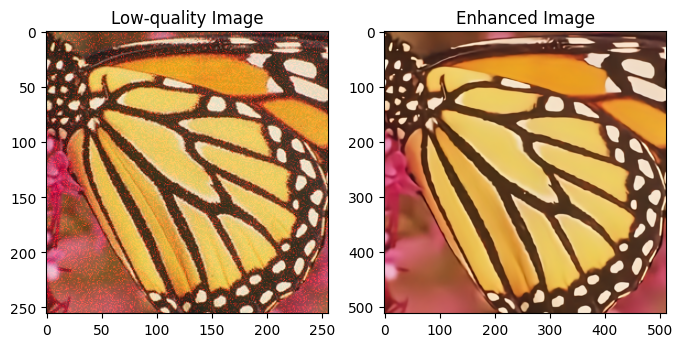

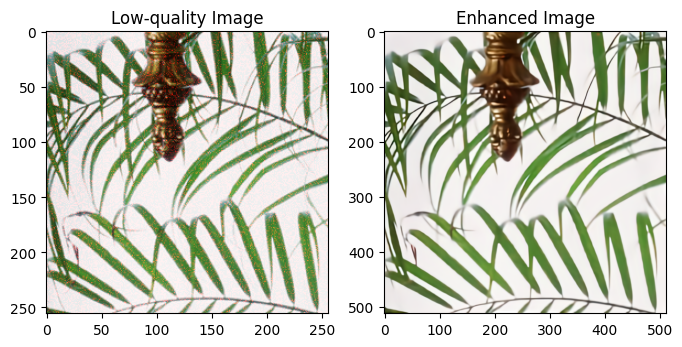

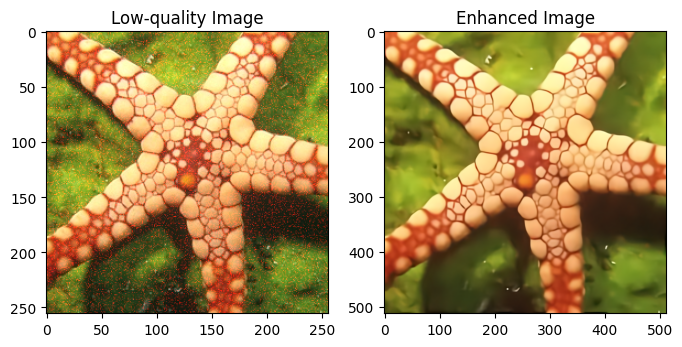

In [ ]:
for idx, img in enumerate(L_paths):

   # (1) get img_L
   # a imagem base é lida do repositório 'testsets' no formato definido pelo
   # parâmetro 'n_channels' (1 = gray scale; 3 = RGB), acrescentamos ruído
   # sobre a imagem e armazenamos em img_L
   img_name, ext = os.path.splitext(os.path.basename(img))
   img_L = util.imread_uint(img, n_channels=n_channels)

   #noise generator
   noise = np.zeros(img_L.shape, np.uint8)
   cv2.randn(noise, mean=0, stddev=60,)
   img_L = cv2.add(img_L, noise)

   img_L = util.uint2single(img_L)

   # (2) get rhos and sigmas
   # definindo os parâmetros rho e sigma da imagem, que definem o posicionamento
   # de linhas e a intensidade de blurring na imagem, respectivamente
   rhos, sigmas = pnp.get_rho_sigma(sigma=max(0.255/255., noise_level_model), iter_num=iter_num, modelSigma1=modelSigma1, modelSigma2=modelSigma2, w=1)
   rhos, sigmas = torch.tensor(rhos).to(device), torch.tensor(sigmas).to(device)

   # (3) initialize x, and pre-calculation
   # operando o resize com fator de escala definido pelo parâmetro 'sf' e
   # shift nos pixels da imagem para adequar as dimensões do upscale,
   # armazenando a imagem resultante em x
   x = cv2.resize(img_L, (img_L.shape[1]*sf, img_L.shape[0]*sf), interpolation=cv2.INTER_CUBIC)

   if np.ndim(x)==2:
      x = x[..., None]

   if classical_degradation:
      x = sr.shift_pixel(x, sf)
   x = util.single2tensor4(x).to(device)

   # convertemos a imagem de baixa qualidade e o filtro de blur em tensores e
   # decompomos a imagem em sinais complexos com canais de frequência distintos
   img_L_tensor, k_tensor = util.single2tensor4(img_L), util.single2tensor4(np.expand_dims(k, 2))
   [k_tensor, img_L_tensor] = util.todevice([k_tensor, img_L_tensor], device)
   FB, FBC, F2B, FBFy = sr_ver8.pre_calculate(img_L_tensor, k_tensor, sf)

   # (4) main iterations
   for i in range(iter_num):

      # step 1, FFT
      # os sinais decompostos da imagem são convergidos de volta em um único
      # sinal com a aplicação de FFTs (Fast Fourier Transforms), utilizando
      # o parâmetro 'tau' como variável auxiliar para conservar as linhas da
      # imagem
      tau = rhos[i].float().repeat(1, 1, 1, 1)
      x = sr_ver8.data_solution(x, FB, FBC, F2B, FBFy, tau, sf)

      # step 2, denoiser
      # aplicamos a imagem no modelo selecionado para tratá-la e tentar
      # restaurá-la, removendo o ruído e aumentando a qualidade da imagem
      if 'ircnn' in model_name:
         current_idx = np.int64(np.ceil(sigmas[i].cpu().numpy()*255./2.)-1)

         if current_idx != former_idx:
            model.load_state_dict(model25[str(current_idx)], strict=True)
            model.eval()
            for _, v in model.named_parameters():
               v.requires_grad = False
            model = model.to(device)
         former_idx = current_idx

      # alterando a orientação da imagem para otimizar o funcionamento do modelo
      if x8:
         x = util.augment_img_tensor4(x, i % 8)

      # aplicação do modelo de processamento
      if 'drunet' in model_name:
         x = torch.cat((x, sigmas[i].repeat(1, 1, x.shape[2], x.shape[3])), dim=1)
         x = utils_model.test_mode(model, x, mode=2, refield=64, min_size=256, modulo=16)
      elif 'ircnn' in model_name:
         x = model(x)

      # retornando a imagem à sua orientação original
      if x8:
         if i % 8 == 3 or i % 8 == 5:
            x = util.augment_img_tensor4(x, 8 - i % 8)
         else:
            x = util.augment_img_tensor4(x, i % 8)

   # (5) img_E
   # salvamos a imagem final processada pelo modelo em img_E
   img_E = util.tensor2uint(x)

   # save images
   util.imsave(img_E, os.path.join(E_path, img_name+'_x'+str(sf)+'_'+model_name+'.png'))
   util.imsave(img_L, os.path.join(E_path, img_name+'_L.png'))

   # plot images
   fig = plt.figure(figsize=(8,8))
   columns = 2
   rows = 1

   ax = []
   ax.append(fig.add_subplot(rows, columns, 1))
   ax[-1].set_title("Low-quality Image")
   plt.imshow(img_L)

   ax.append(fig.add_subplot(rows, columns, 2))
   ax[-1].set_title("Enhanced Image")
   plt.imshow(img_E)

   plt.show()